# Performance Metrics

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from typing import List, Dict, Tuple, Optional, Union
import pandas as pd
import sys
import os
from matplotlib import colors
from skimage.metrics import structural_similarity as ssim
from scipy.signal import correlate2d, find_peaks
from scipy.ndimage import gaussian_filter
import random
import importlib
from tqdm import tqdm
import h5py
import re
import json
from collections import defaultdict

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))
import utils.ptychosaxsNN_utils as ptNN_U
importlib.reload(ptNN_U)
from utils.model_comparer import ModelComparer

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/models/')))

## Initialize ModelComparer()

In [2]:
# Initialize the comparer
comparer = ModelComparer()

probe_sizes=[256]#,256]#,128]
lattice_types=['ClathII']#,'SC']#,'ClathII']
unet_statuses=['Unet']#,'no_Unet']#,'no_Unet']#,'Unet']#,'no_Unet']
loss_functions=['pearson_loss']#,'L1','L2']#,'L1','L2']
noise_statuses=['Noise']#,'noNoise']#,'Noise']
files=[2,25,250]#[25]#[2,10,25,50,100,150,200,250,300,400,500]
base_path="/net/micdata/data2/12IDC/ptychosaxs/"
model_list=[base_path + f'batch_mode_250/trained_model/best_model_Lattice{lattice_type}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise_status}_sim_ZCB_9_3D_S5065_N600_steps4_dp256_{unet_status}_epoch_{f}_{loss_function}_symmetry_0.0.pth' for f in files for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
model_list_info =[f'Lattice{lattice_type}_Probe{probe_size}x{probe_size}_{noise_status}_{unet_status}_{loss_function}' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]


model_configs = {
    'iterations': files,
    'models': {
        'pearson_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        #'pearson_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        'L1_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth',
        #'L1_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0.pth',
        'L2_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth',
        #'L2_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L2_symmetry_0.0.pth',
    }
}

print("ModelComparer class initialized successfully!")
print(f"Using device: {comparer.device}")

ModelComparer class initialized successfully!
Using device: cuda


## Load example data

Loading data from: /net/micdata/data2/12IDC/ptychosaxs/batch_mode/hkl/LatticeClathII_Probe256x256_ZCB_9_3D__Noise_hkl111/sim_ZCB_9_3D_S5065_N1_steps4_dp256.h5
<KeysViewHDF5 ['convDP', 'indices_ik', 'pinholeDP', 'pinholeDP_raw_FFT', 'probe', 'probe_center_xy', 'rotation_angles']>
Loaded 16 diffraction patterns
Pattern shapes - conv_DPs: (16, 256, 256), ideal_DPs: (16, 256, 256)
Using index 3


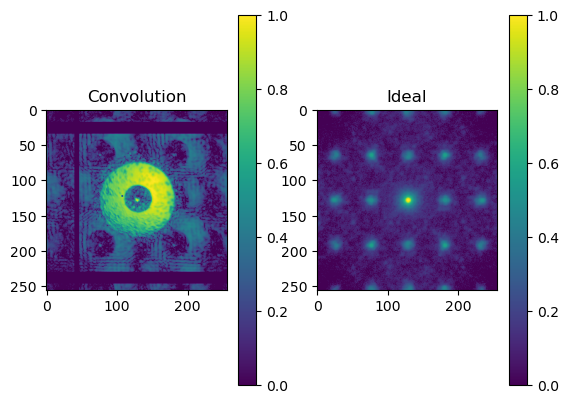

In [3]:
# Load the input data
mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
hr,kr,lr=1,1,1#1,1,0
h5file_data=f'/net/micdata/data2/12IDC/ptychosaxs/batch_mode/hkl/LatticeClathII_Probe256x256_ZCB_9_3D__Noise_hkl{hr}{kr}{lr}/sim_ZCB_9_3D_S5065_N1_steps4_dp256.h5'
# Load data directly from the HDF5 file
print(f"Loading data from: {h5file_data}")

with h5py.File(h5file_data, "r") as h5f:
    # Load convDP and pinholeDP_raw_FFT as conv and ideal diffraction patterns
    conv_DPs = h5f['convDP'][:]  # Shape: (16, 256, 256)
    ideal_DPs = h5f['pinholeDP_raw_FFT'][:]  # Shape: (16, 256, 256)
    
    print(h5f.keys())
    num_patterns = len(conv_DPs)
    print(f"Loaded {num_patterns} diffraction patterns")
    print(f"Pattern shapes - conv_DPs: {conv_DPs.shape}, ideal_DPs: {ideal_DPs.shape}")

# Create dummy probe array (as before)
probe_DPs = np.ones(conv_DPs.shape)  # dummy array for testing network with a probe

# Display a random pattern to verify the data
ri = np.random.randint(0, len(conv_DPs))
#ri=10
print(f"Using index {ri}")

dp_pp,_,_ = ptNN_U.preprocess_ZCB_9(conv_DPs[ri],mask)
dp_pp_IDEAL,_,_ = ptNN_U.preprocess_ZCB_9(ideal_DPs[ri],mask=np.ones(dp_pp[0][0].shape))

#%%
# Ensure data is in correct format
dp_pp = comparer.ensure_tensor_format(dp_pp)
dp_pp_IDEAL = comparer.ensure_tensor_format(dp_pp_IDEAL)

fig,ax = plt.subplots(1,2)
im1=ax[0].imshow(dp_pp.squeeze().cpu().numpy())
im2=ax[1].imshow(dp_pp_IDEAL.squeeze().cpu().numpy())
plt.colorbar(im1,ax=ax[0])
plt.colorbar(im2,ax=ax[1])
ax[0].set_title('Convolution')
ax[1].set_title('Ideal')
plt.show()



## Set peak finding parameters

In [4]:
comparer.default_peak_sigma = 0.714*2
comparer.default_peak_threshold = 0.265*1.07
comparer.peak_distance_threshold = 12.0
comparer.ideal_peak_smoothing_sigma = 1.0
comparer.percentile_threshold_value = 96.
comparer.output_percentile_threshold_value = comparer.percentile_threshold_value
comparer.use_percentile_threshold = True

## Create comparison grid based on model_configs

Found 25 output peaks vs 22 ideal peaks
Found 24 output peaks vs 22 ideal peaks
Found 18 output peaks vs 22 ideal peaks
Found 16 output peaks vs 22 ideal peaks
Found 16 output peaks vs 22 ideal peaks
Found 19 output peaks vs 22 ideal peaks
Found 18 output peaks vs 22 ideal peaks
Found 20 output peaks vs 22 ideal peaks
Found 20 output peaks vs 22 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1036: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


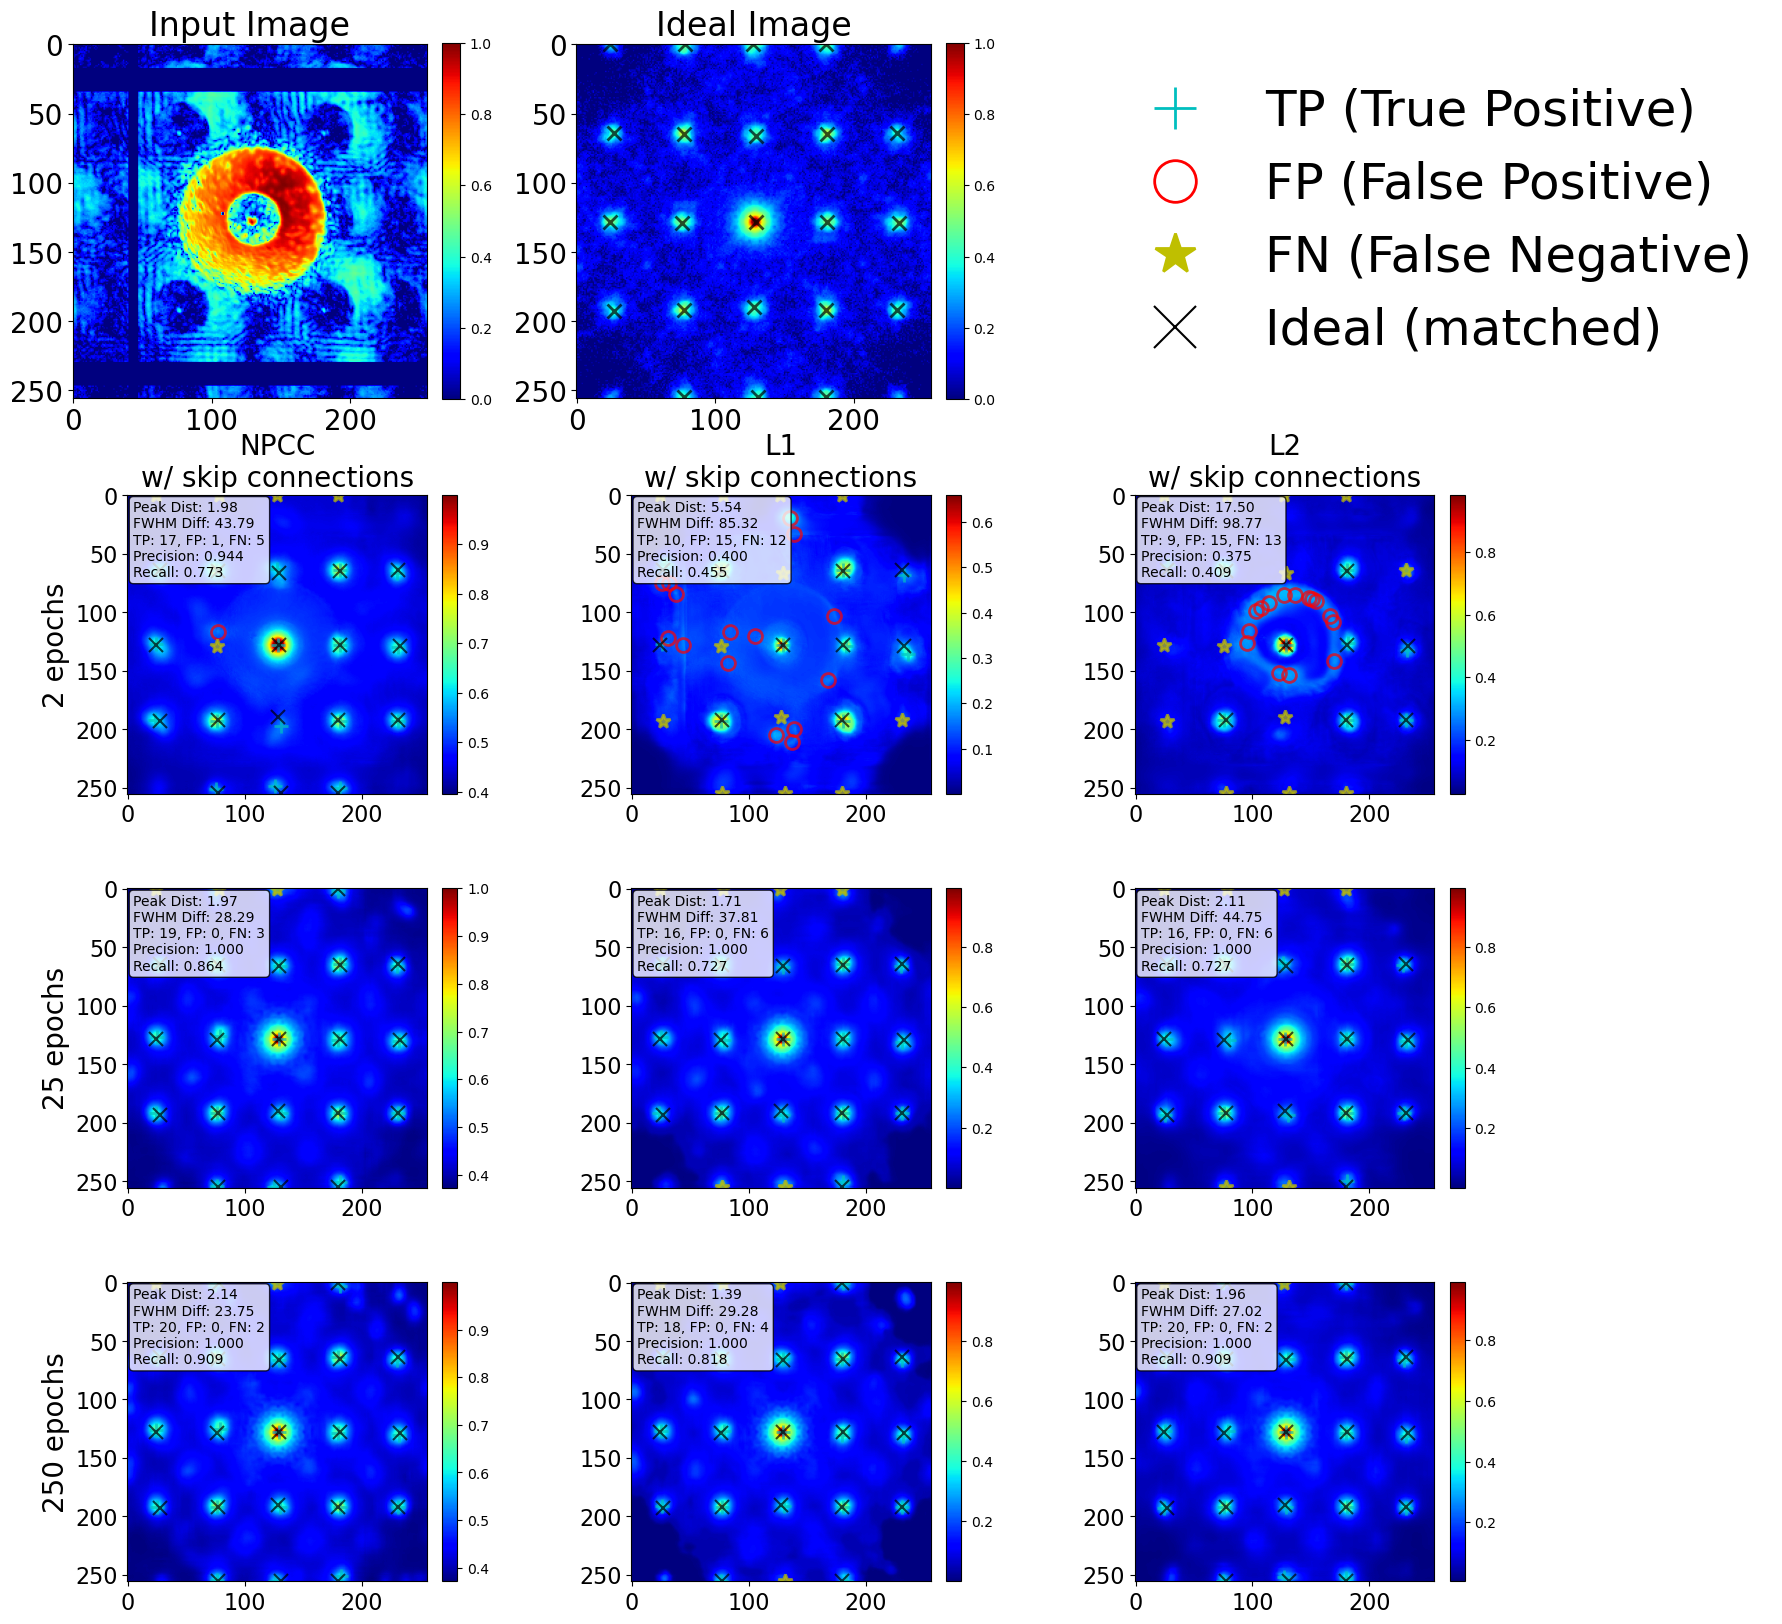

In [5]:
# Create comparison grid
fig = comparer.create_comparison_grid(
    model_configs=model_configs,
    input_data=dp_pp,
    ideal_data=dp_pp_IDEAL,
    figsize=(15, 15),
    calculate_psnr=False,
    calculate_ssim=False,
    calculate_xcorr=False,
    show_peak_classification=True,
    calculate_peaks=True,
)

In [6]:
# Example 1: Print all epochs separately (grouped by model type)
comparer.print_stats_from_file(
    "../data/stats/cumulative_stats_summed_96.0percentile.txt",
    sort_by='avg_peak_f1',
    group_by_model=False,
    aggregate_epochs=False
)


Loaded stats from: ../data/stats/cumulative_stats_summed_96.0percentile.txt
Showing all epochs separately

Cumulative Statistics Per Model and Iteration (sorted by avg_peak_f1):

                  Model avg_peak_precision avg_peak_recall avg_peak_f1 peak_detection_rate avg_psnr avg_ssim avg_peak_dist avg_fwhm_diff total_peak_tp total_peak_fp total_peak_fn total_peaks_matched total_peaks_ideal angles_processed avg_xcorr
15        L2_no_Unet_25             0.9012          0.7775      0.8331              0.7746  28.4820   0.7297        1.3974       28.7068         2,959           354           861               2,959             3,820              180    0.0000
20           L2_Unet_50             0.8902          0.7875      0.8329              0.7846  28.6418   0.7360        1.1296       31.0412         2,997           418           823               2,997             3,820              180    0.0000
10      pearson_Unet_10             0.8793          0.7955      0.8326              0.79

In [42]:
# Find specific stats
print(comparer.find_stats_by_model_and_epoch(
    "../data/stats/cumulative_stats_96.0percentile.txt",
    loss_function='L2',#'L2' #'L1' #'pearson'
    epoch=250,
    has_skip_connections=True  # True for Unet, False for no_Unet, None for both
))


Stats for loss_function='l2', epoch=250, has_skip_connections=True
            Model avg_peak_precision avg_peak_recall avg_peak_f1 peak_detection_rate avg_psnr avg_ssim avg_peak_dist avg_fwhm_diff total_peak_tp total_peak_fp total_peak_fn total_peaks_matched total_peaks_ideal patterns_processed avg_xcorr
0     L2_Unet_250             0.8215          0.7309      0.7698              0.7256  26.1361   0.4742        3.6321       35.0191        45,323        11,243        17,138              45,323            62,461              2,880    0.0000
1  L2_no_Unet_250             0.8231          0.7338      0.7726              0.7289  26.0921   0.4737        3.1950       33.5735        45,526        11,016        16,935              45,526            62,461              2,880    0.0000
{'L2_Unet_250': {'avg_psnr': 26.13605929899859, 'avg_ssim': 0.47423143497708525, 'avg_xcorr': 0.0, 'avg_peak_dist': 3.6320787136707042, 'avg_fwhm_diff': 35.01908399575057, 'peak_detection_rate': 0.725620787371319

## Zoom in on comparison figure

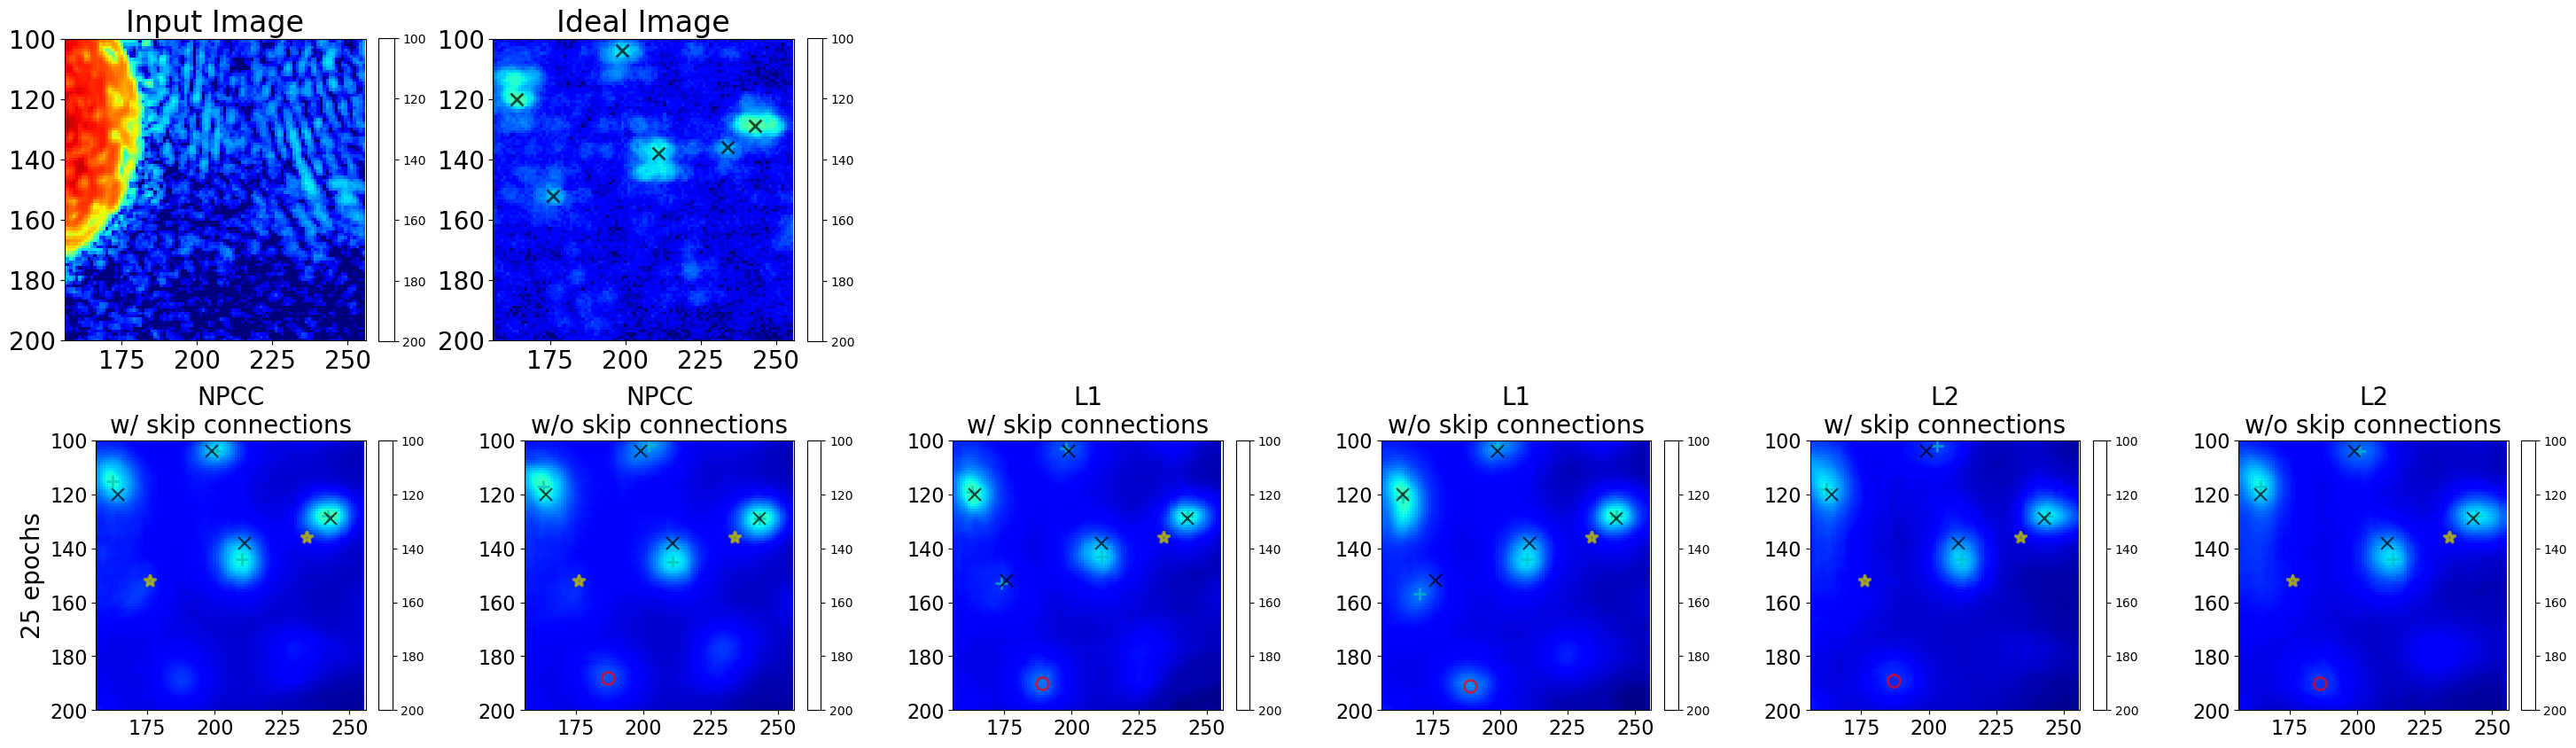

In [41]:
# To zoom in on a part of this figure, set x/y limits on *each main image axes*, not all axes (don't set limits on colorbar axes!).
# To remove all matplotlib legends and overlays (such as text annotations) from each axes:
for ax in fig.axes:
    # Remove legend if present
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    # Remove all text annotations (including overlays like "Peak dist:")
    for text in ax.texts:
        text.set_visible(False)
    # Example: zoom in to a central region. Adjust these as needed!
    ax.set_xlim(156, 256)   # left to right (pixel columns)
    ax.set_ylim(200, 100)   # top to bottom (pixel rows), inverted for image origin='upper'
fig

In [7]:
# loss_figures = comparer.plot_loss_comparison(
#     data_dir="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/",
#     expected_epochs=[2, 5, 10, 25, 50, 100, 150, 200, 250],
#     expected_losses=['L1', 'L2', 'pearson_loss'],
#     show_normalized=True,
#     show_combined=True,
#     figsize=(16, 12)
# )

## Run for multiple

--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [2], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0

Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

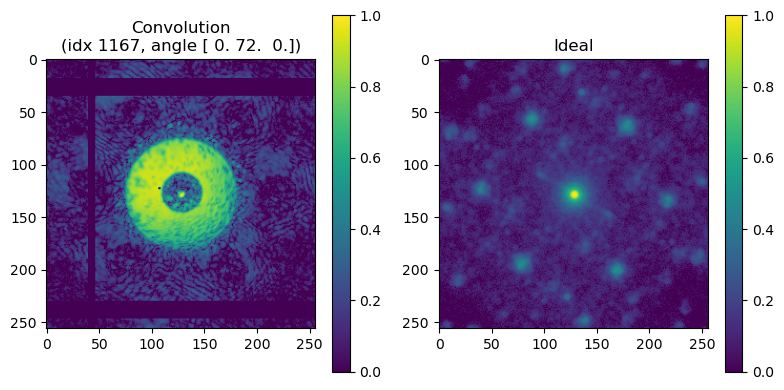

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [10], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.

Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

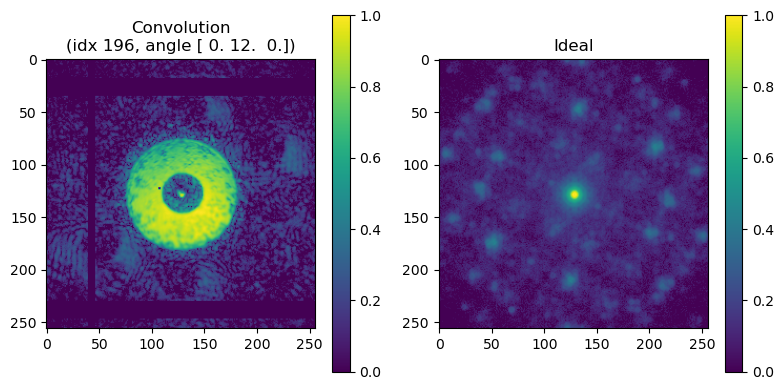

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [25], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.

KeyboardInterrupt: 

In [6]:
files=[2,10,25]#,50,100,150,200,250]
stats_list = []
for epoch in files: 
    # Initialize the comparer
    comparer = ModelComparer()

    # Define model parameters
    probe_sizes=[256]#,256]#,128]
    lattice_types=['ClathII']#,'SC']#,'ClathII']
    unet_statuses=['Unet']#,'no_Unet']#,'no_Unet']#,'Unet']#,'no_Unet']
    loss_functions=['pearson_loss']#,'L1','L2']#,'L1','L2']
    noise_statuses=['Noise']#,'noNoise']#,'Noise']
    epochs=[epoch]#2,10,25,50,100,150,200,250,300,400,500]
    base_path="/net/micdata/data2/12IDC/ptychosaxs/"
    model_list=[base_path + f'batch_mode_250/trained_model/best_model_Lattice{lattice_type}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise_status}_sim_ZCB_9_3D_S5065_N600_steps4_dp256_{unet_status}_epoch_{epoch}_{loss_function}_symmetry_0.0.pth' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
    model_list_info =[f'Lattice{lattice_type}_Probe{probe_size}x{probe_size}_{noise_status}_{unet_status}_{loss_function}' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
    # }

    model_configs = {
        'iterations': epochs,
        'models': {
            'pearson_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
            'pearson_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
            'L1_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth',
            'L1_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0.pth',
            'L2_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth',
            'L2_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L2_symmetry_0.0.pth',
        }
    }

    print('--------------------------------')
    print("ModelComparer class initialized successfully!")
    print(f"Using device: {comparer.device}")
    print('model_configs: ', model_configs)
    print('Epoch: ', epoch)
    print('--------------------------------')

    # Load and plot selected angle indices from the .h5 file
    h5_file_path = "/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/tomo_tests/LatticeClathII_Probe256x256_Noise/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5"
    ri=random.randint(0, 179)
    #angle_indices = [ri]  # Modify as needed, e.g., [0, 1, 2] to plot more angles
    angle_indices = [ri] #61, WEAK DIFFRACTION #[51]# [135]#hex pattern    #[50]#strong diffraction        #[20]#weak diffraction pattern
    print(f"Selected angle index: {angle_indices}")
    mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
        
    with h5py.File(h5_file_path, 'r') as h5file:
        # Check that datasets exist
        if 'convDP' not in h5file:
            raise ValueError(f"Key 'convDP' not found in h5 file: {h5_file_path}")
        if 'pinholeDP_raw_FFT' not in h5file:
            raise ValueError(f"Key 'pinholeDP_raw_FFT' not found in h5 file: {h5_file_path}")

        convDP = h5file['convDP'][:]
        pinholeDP_raw_FFT = h5file['pinholeDP_raw_FFT'][:]
        rotation_angles = h5file['rotation_angles'][:] if 'rotation_angles' in h5file else None

        num_patterns = convDP.shape[0]
        num_angles = rotation_angles.shape[0] if rotation_angles is not None else 1

        # Determine the patterns per angle
        patterns_per_angle = num_patterns // num_angles if num_angles > 0 else num_patterns

        # Gather pattern indices corresponding to the selected angles
        selected_pattern_indices = []
        for angle_idx in angle_indices:
            start_idx = angle_idx * patterns_per_angle
            end_idx = min(start_idx + patterns_per_angle, num_patterns)
            selected_pattern_indices.extend(range(start_idx, end_idx))
        
        selected_scan_point = random.randint(0,16)
        selected_pattern_indices = selected_pattern_indices[selected_scan_point:selected_scan_point+1]#[2:3]#[0:1]

        # Plot results for each pattern of selected angles
        for pi in tqdm(selected_pattern_indices, desc="Plotting selected angle indices"):
            convDP_pattern = convDP[pi]
            pinholeDP_pattern = pinholeDP_raw_FFT[pi]
            
            dp_pp, _, _ = ptNN_U.preprocess_ZCB_9(convDP_pattern, mask)
            dp_pp_IDEAL, _, _ = ptNN_U.preprocess_ZCB_9(pinholeDP_pattern, mask=np.ones(dp_pp[0][0].shape))
            
            # If you want to use torch/cuda, adapt as needed (e.g., dp_pp = torch.tensor(...))
            dp_pp = comparer.ensure_tensor_format(dp_pp)
            dp_pp_IDEAL = comparer.ensure_tensor_format(dp_pp_IDEAL)

            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            im1 = ax[0].imshow(dp_pp.squeeze().cpu().numpy())
            im2 = ax[1].imshow(dp_pp_IDEAL.squeeze().cpu().numpy())
            plt.colorbar(im1, ax=ax[0])
            plt.colorbar(im2, ax=ax[1])
            ax[0].set_title(f'Convolution\n(idx {pi}, angle {rotation_angles[pi//patterns_per_angle] if rotation_angles is not None else "?"})')
            ax[1].set_title('Ideal')
            plt.tight_layout()
            plt.show()

    comparer.default_peak_sigma = 0.714*2
    comparer.default_peak_threshold = 0.265*1.07
    comparer.peak_distance_threshold = 12.0
    comparer.ideal_peak_smoothing_sigma = 1.0
    comparer.percentile_threshold_value = 96.
    comparer.output_percentile_threshold_value = comparer.percentile_threshold_value
    comparer.use_percentile_threshold = True

# Create comparison grid
fig = comparer.create_comparison_grid(
    model_configs=model_configs,
    base_path="/net/micdata/data2/12IDC/ptychosaxs/models/ZCB_9_3D/",
    input_data=dp_pp,
    ideal_data=dp_pp_IDEAL,
    figsize=(15, 15),
    calculate_psnr=False,
    calculate_ssim=False,
    calculate_xcorr=False,
    calculate_peaks=True,
    show_peak_classification=True,
)
plt.show()


print('--------------------------------')
print('Comparer peak parameters:')
print(comparer.default_peak_sigma)
print(comparer.default_peak_threshold)
print(comparer.peak_distance_threshold)
print(comparer.ideal_peak_smoothing_sigma)
print(comparer.percentile_threshold_value)
print(comparer.use_percentile_threshold)
print('--------------------------------')

--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [2, 25, 250], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L2_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth'}}
Epoch:  2
--------------------------------
Selected angle index: [124]


Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

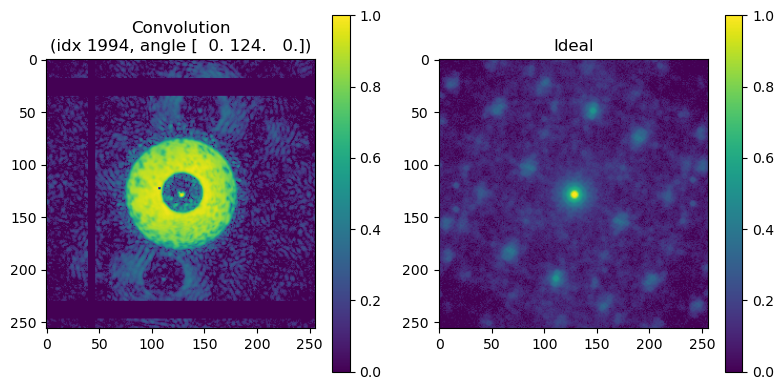

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Found 45 output peaks vs 19 ideal peaks
Found 20 output peaks vs 19 ideal peaks
Found 21 output peaks vs 19 ideal peaks
Found 16 output peaks vs 19 ideal peaks
Found 19 output peaks vs 19 ideal peaks
Found 14 output peaks vs 19 ideal peaks
Found 14 output peaks vs 19 ideal peaks
Found 15 output peaks vs 19 ideal peaks
Found 15 output peaks vs 19 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1035: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


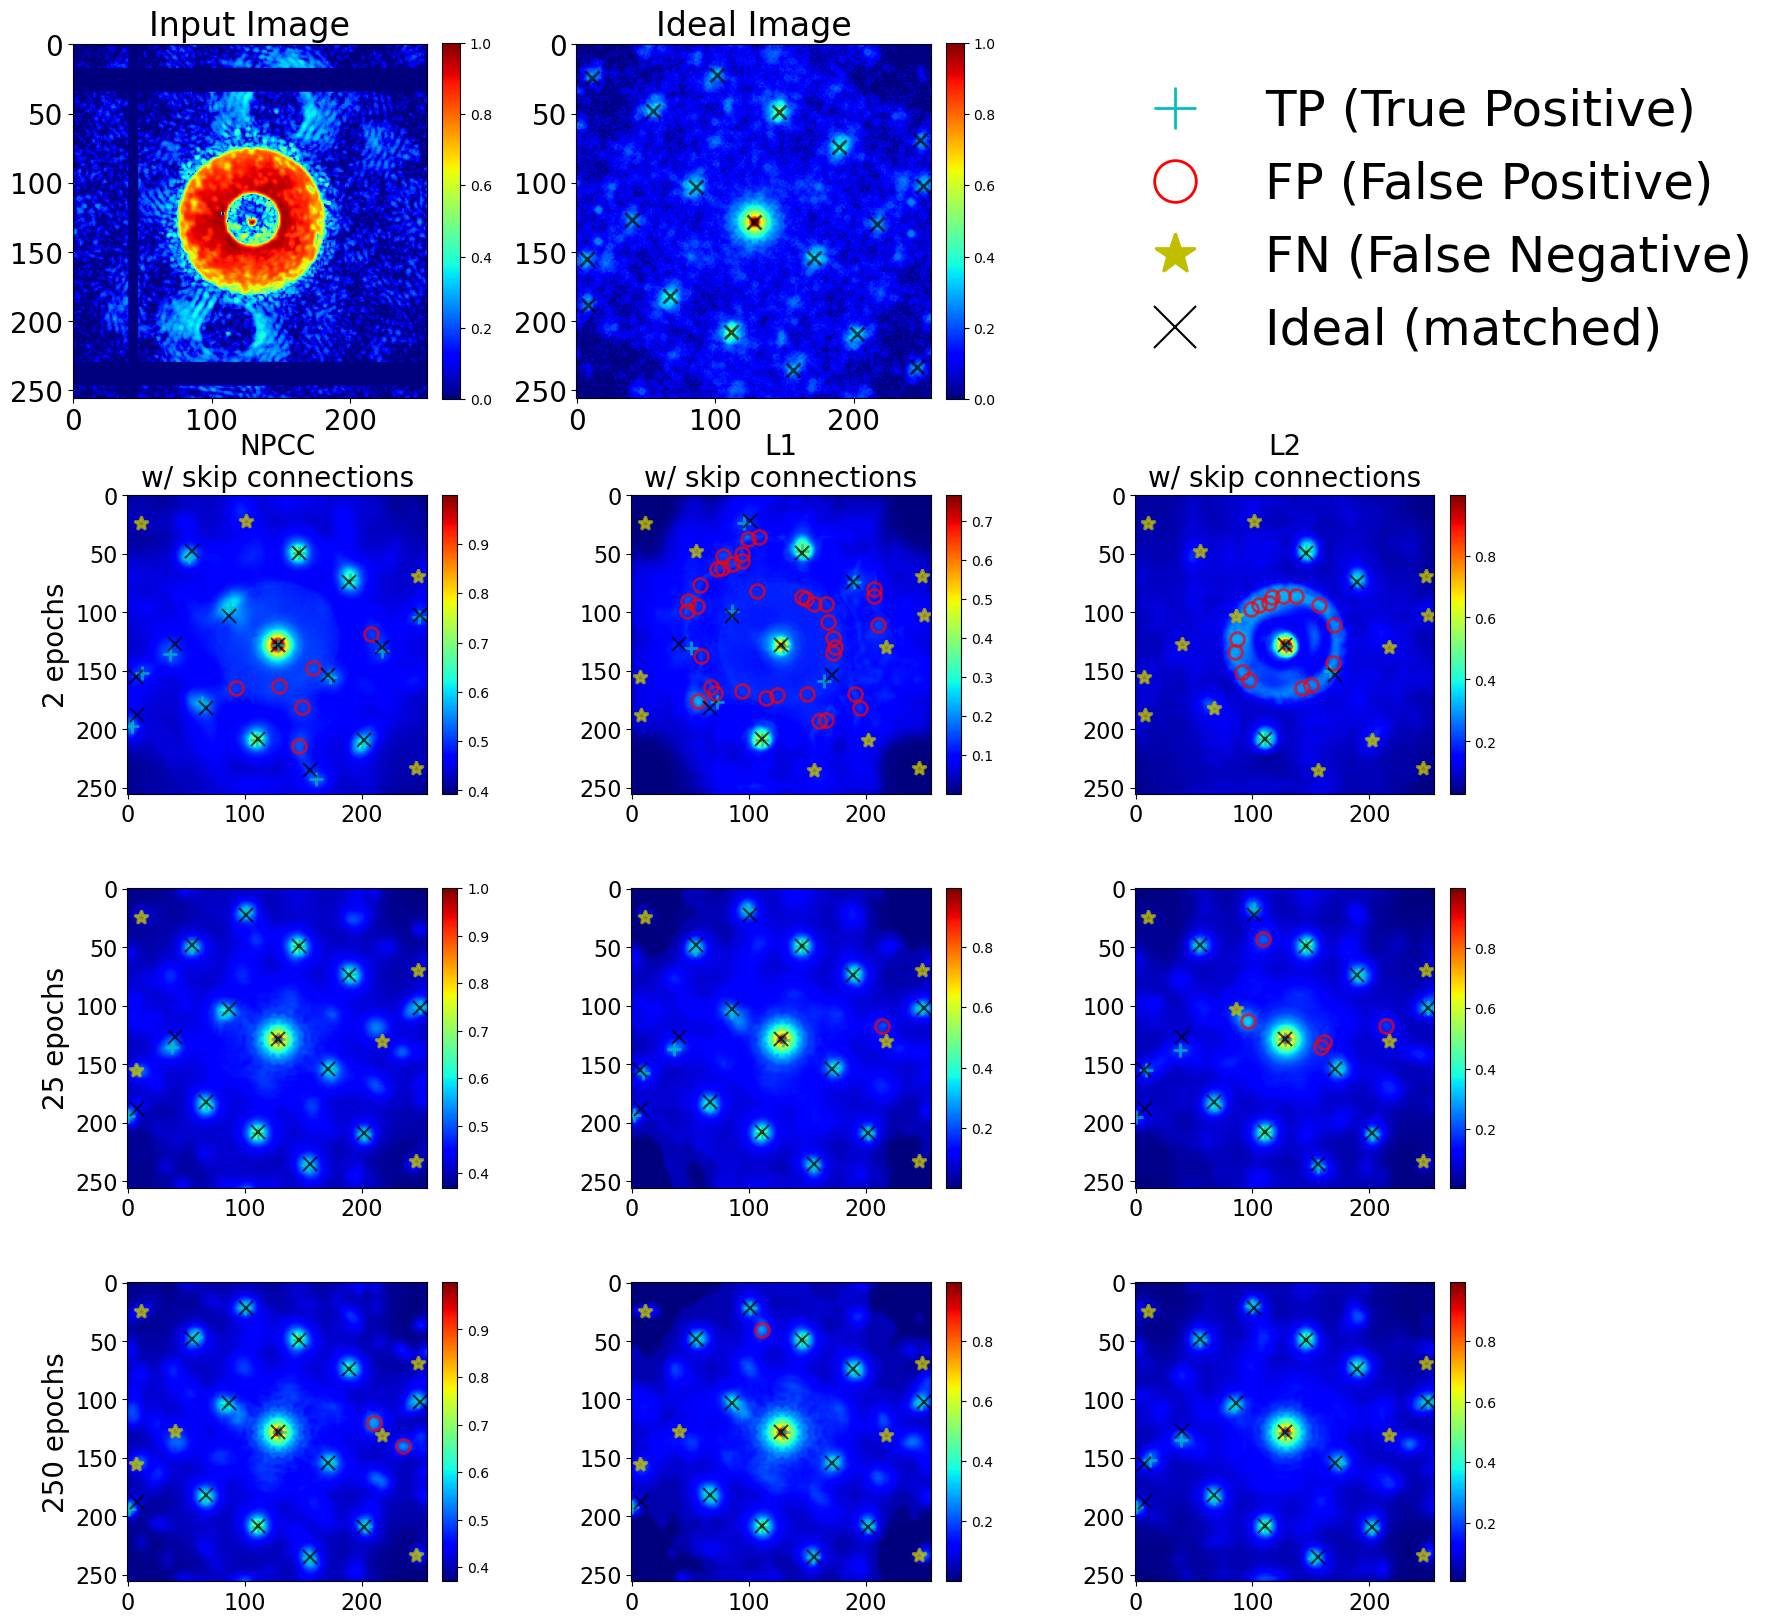

In [25]:


# Initialize the comparer
comparer = ModelComparer()

probe_sizes=[256]#,256]#,128]
lattice_types=['ClathII']#,'SC']#,'ClathII']
unet_statuses=['Unet']#,'no_Unet']#,'no_Unet']#,'Unet']#,'no_Unet']
loss_functions=['pearson_loss']#,'L1','L2']#,'L1','L2']
noise_statuses=['Noise']#,'noNoise']#,'Noise']
epochs=[2,25,250]
epoch=2
base_path="/net/micdata/data2/12IDC/ptychosaxs/"
model_list=[base_path + f'batch_mode_250/trained_model/best_model_Lattice{lattice_type}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise_status}_sim_ZCB_9_3D_S5065_N600_steps4_dp256_{unet_status}_epoch_{epoch}_{loss_function}_symmetry_0.0.pth' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
model_list_info =[f'Lattice{lattice_type}_Probe{probe_size}x{probe_size}_{noise_status}_{unet_status}_{loss_function}' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
# }

model_configs = {
    'iterations': epochs,
    'models': {
        'pearson_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        #'pearson_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        'L1_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth',
        #'L1_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0.pth',
        'L2_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth',
        #'L2_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L2_symmetry_0.0.pth',
    }
}

print('--------------------------------')
print("ModelComparer class initialized successfully!")
print(f"Using device: {comparer.device}")
print('model_configs: ', model_configs)
print('Epoch: ', epoch)
print('--------------------------------')

# Load and plot selected angle indices from the .h5 file
h5_file_path = "/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/tomo_tests/LatticeClathII_Probe256x256_Noise/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5"
ri=random.randint(0, 179)
#angle_indices = [ri]  # Modify as needed, e.g., [0, 1, 2] to plot more angles
angle_indices = [124]#[ri] #61, WEAK DIFFRACTION #[51]# [135]#hex pattern    #[50]#strong diffraction        #[20]#weak diffraction pattern
print(f"Selected angle index: {angle_indices}")
mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
    
with h5py.File(h5_file_path, 'r') as h5file:
    # Check that datasets exist
    if 'convDP' not in h5file:
        raise ValueError(f"Key 'convDP' not found in h5 file: {h5_file_path}")
    if 'pinholeDP_raw_FFT' not in h5file:
        raise ValueError(f"Key 'pinholeDP_raw_FFT' not found in h5 file: {h5_file_path}")

    convDP = h5file['convDP'][:]
    pinholeDP_raw_FFT = h5file['pinholeDP_raw_FFT'][:]
    rotation_angles = h5file['rotation_angles'][:] if 'rotation_angles' in h5file else None

    num_patterns = convDP.shape[0]
    num_angles = rotation_angles.shape[0] if rotation_angles is not None else 1

    # Determine the patterns per angle
    patterns_per_angle = num_patterns // num_angles if num_angles > 0 else num_patterns

    # Gather pattern indices corresponding to the selected angles
    selected_pattern_indices = []
    for angle_idx in angle_indices:
        start_idx = angle_idx * patterns_per_angle
        end_idx = min(start_idx + patterns_per_angle, num_patterns)
        selected_pattern_indices.extend(range(start_idx, end_idx))
    
    selected_scan_point = 10#random.randint(0,16)
    selected_pattern_indices = selected_pattern_indices[selected_scan_point:selected_scan_point+1]#[2:3]#[0:1]

    # Plot results for each pattern of selected angles
    for pi in tqdm(selected_pattern_indices, desc="Plotting selected angle indices"):
        convDP_pattern = convDP[pi]
        pinholeDP_pattern = pinholeDP_raw_FFT[pi]
        
        dp_pp, _, _ = ptNN_U.preprocess_ZCB_9(convDP_pattern, mask)
        dp_pp_IDEAL, _, _ = ptNN_U.preprocess_ZCB_9(pinholeDP_pattern, mask=np.ones(dp_pp[0][0].shape))
        
        # If you want to use torch/cuda, adapt as needed (e.g., dp_pp = torch.tensor(...))
        # dp_pp = dp_pp.to(device=comparer.device, dtype=torch.float)
        # dp_pp_IDEAL = dp_pp_IDEAL.to(device=comparer.device, dtype=torch.float)
        dp_pp = comparer.ensure_tensor_format(dp_pp)
        dp_pp_IDEAL = comparer.ensure_tensor_format(dp_pp_IDEAL)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        im1 = ax[0].imshow(dp_pp.squeeze().cpu().numpy())
        im2 = ax[1].imshow(dp_pp_IDEAL.squeeze().cpu().numpy())
        plt.colorbar(im1, ax=ax[0])
        plt.colorbar(im2, ax=ax[1])
        ax[0].set_title(f'Convolution\n(idx {pi}, angle {rotation_angles[pi//patterns_per_angle] if rotation_angles is not None else "?"})')
        ax[1].set_title('Ideal')
        plt.tight_layout()
        plt.show()
    
    comparer.default_peak_sigma = 0.714*2
    comparer.default_peak_threshold = 0.265*1.07#0.265*1.5#0.265*1.05
    comparer.peak_distance_threshold = 12.0
    comparer.ideal_peak_smoothing_sigma = 1.0#None#0.5#0.8 # None
    comparer.percentile_threshold_value = 96.
    comparer.output_percentile_threshold_value = comparer.percentile_threshold_value
    comparer.use_percentile_threshold = True

    # comparer.default_peak_sigma = 0.714*2
    # comparer.default_peak_threshold = 0.265*1.1#0.265*1.5#0.265*1.05
    # comparer.peak_distance_threshold = 8.0
    # comparer.ideal_peak_smoothing_sigma = 0.8#0.8 # None
    # Create comparison grid
    fig = comparer.create_comparison_grid(
        model_configs=model_configs,
        base_path="/net/micdata/data2/12IDC/ptychosaxs/models/ZCB_9_3D/",
        input_data=dp_pp,
        ideal_data=dp_pp_IDEAL,
        figsize=(15, 15),
        calculate_psnr=False,
        calculate_ssim=False,
        calculate_xcorr=False,
        calculate_peak_sensitivity=False,
        calculate_peaks=True,
        show_peak_classification=True,
    )
    plt.show()




## Cumulative statistics for a given set of patterns

In [ ]:
print('--------------------------------')
print('Comparer peak parameters:')
print(comparer.default_peak_sigma)
print(comparer.default_peak_threshold)
print(comparer.peak_distance_threshold)
print(comparer.ideal_peak_smoothing_sigma)
print(comparer.percentile_threshold_value)
print(comparer.use_percentile_threshold)
print('--------------------------------')
stats = comparer.calculate_cumulative_stats_from_h5(
model_configs=model_configs,
h5_file_path="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/tomo_tests/LatticeClathII_Probe256x256_Noise/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5",
base_path="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/",
calculate_peaks=True,
angle_indices=angle_indices,#list(range(0,180)),#sorted(random.sample(range(0, 180), 9)),#list(range(0,180,20)),#[0,45,90,135]
show_peak_classification=True,
)

comparer.print_cumulative_stats(stats, sort_by='avg_peak_precision')  # Sort by SSIM
comparer.print_cumulative_stats(stats, sort_by='peak_detection_rate')  # Sort by peak detection rate
comparer.print_cumulative_stats(stats, sort_by='avg_peak_f1')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='avg_peak_recall')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_tp')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_fp')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_fn')  # Sort by PSNR

stats_list.append(stats)


print('--------------------------------')
print('--------------------------------')
print('--------------------------------')
print('--------------------------------')
print('--------------------------------')

## Plot comparison cumulative statistics

Summed data by model:
  L1_Unet: [(2, 23.362509926275127), (10, 25.913018223994058), (25, 26.112964386730553), (50, 26.234263589044545), (100, 25.94430095501549), (150, 25.89788431205244), (200, 25.993961104238682), (250, 25.963934432806404)]
  L1_no_Unet: [(2, 24.59529689352135), (10, 25.488535525987768), (25, 25.900366385499147), (50, 26.022582370483505), (100, 26.193488405957385), (150, 25.97596342147738), (200, 25.882588966941253), (250, 26.021053917923787)]
  L2_Unet: [(2, 23.380494446543278), (10, 25.727066756802813), (25, 25.7777118721372), (50, 25.988759238530182), (100, 26.028992899664217), (150, 26.134922201187308), (200, 26.00047878869832), (250, 26.13605929899859)]
  L2_no_Unet: [(2, 24.231029910101803), (10, 25.437167921186482), (25, 25.996942684440967), (50, 26.065404617732742), (100, 26.176418918969354), (150, 26.09685756484425), (200, 26.150108987738875), (250, 26.092087297678898)]
  pearson_Unet: [(2, 24.81630339562424), (10, 26.22591021346673), (25, 26.434123309690268

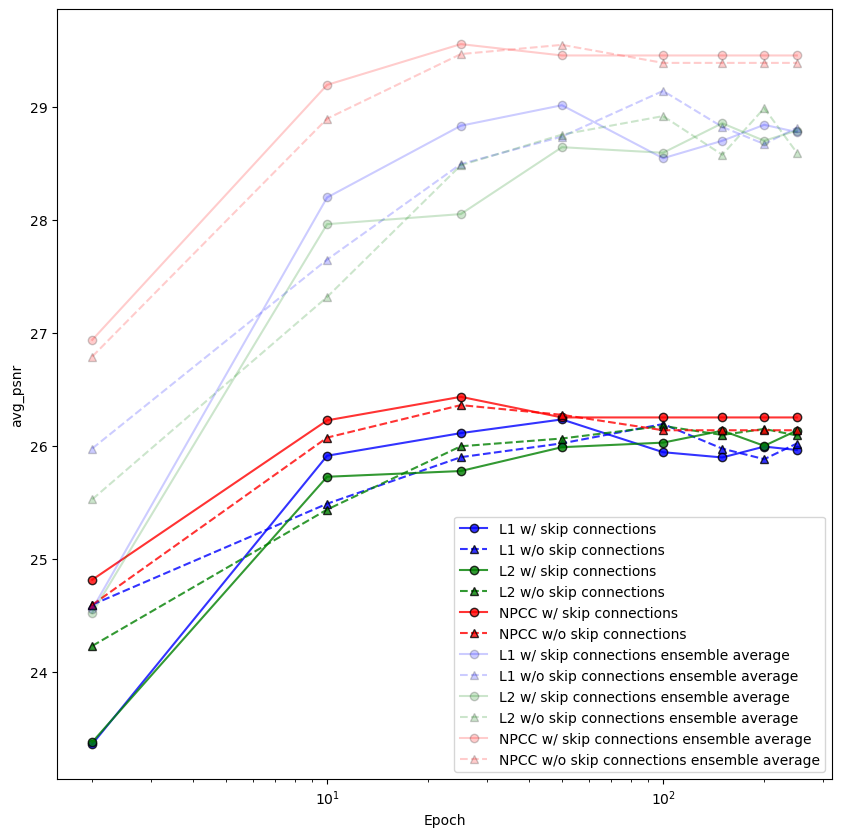

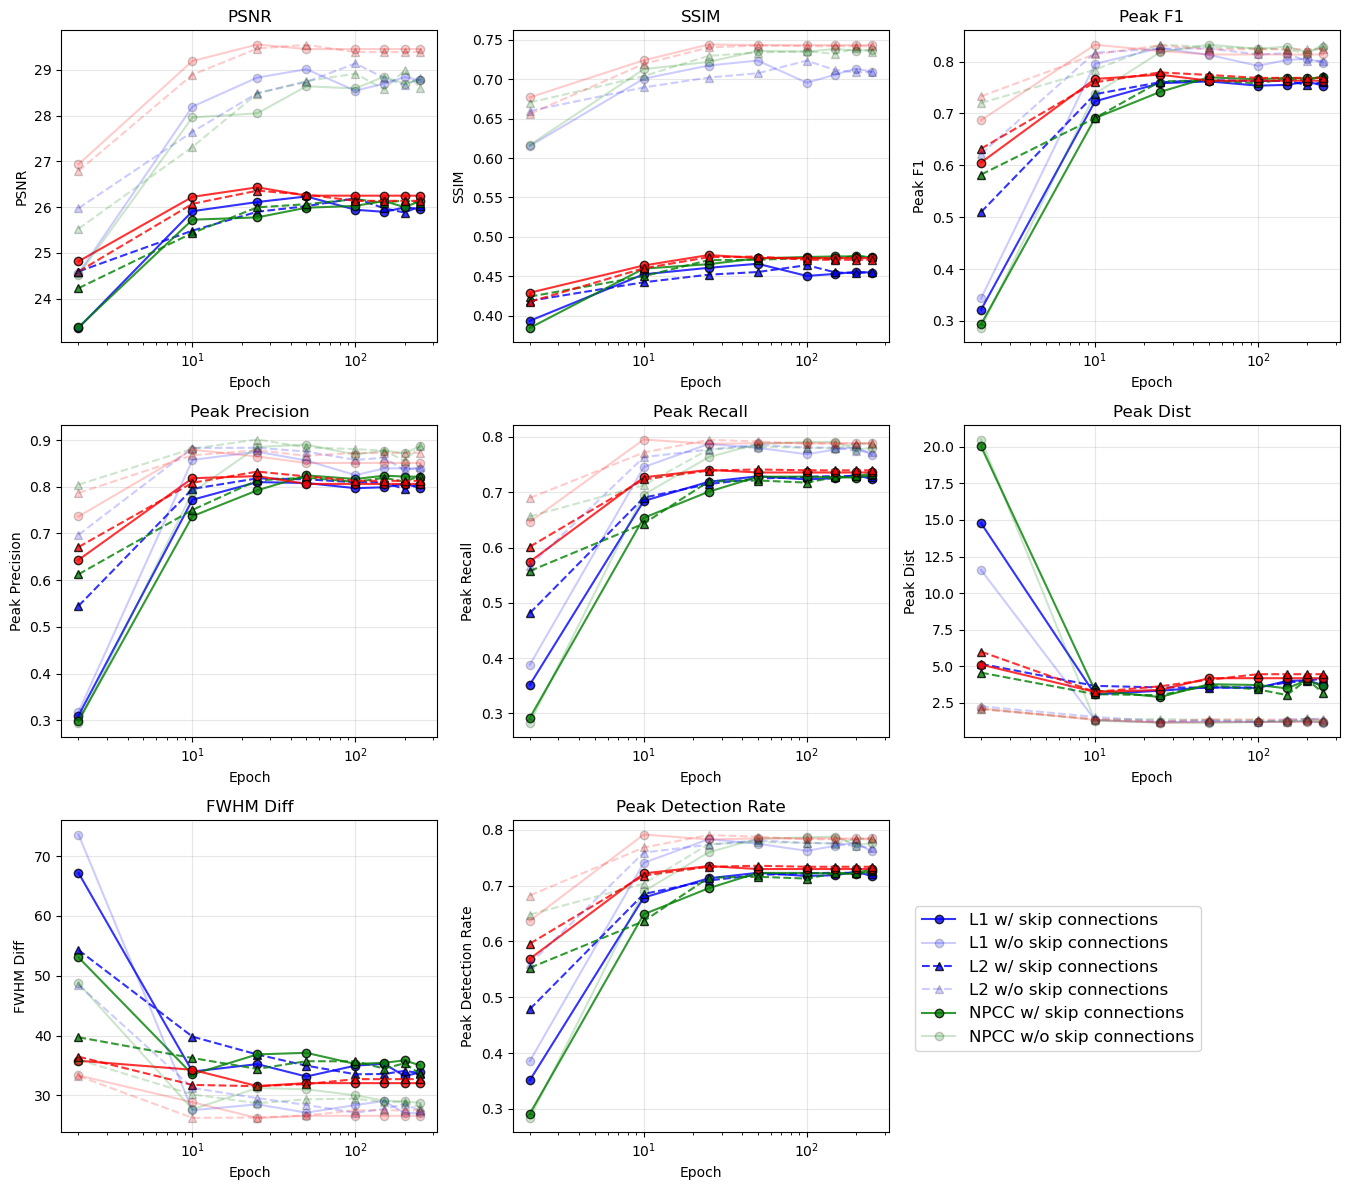

In [ ]:
# Shared color mapping for loss functions (matching plot_loss_vs_epoch_combined)
def get_loss_function_color(model_name):
    """Get color for a model based on its loss function"""
    loss_color_map = {
        'L1': 'blue',
        'L2': 'green',
        'pearson': 'red',
        'pearson_loss': 'red'  # Also handle the loss plot naming
    }
    # Extract loss function from model name
    for loss_func in loss_color_map.keys():
        if model_name.startswith(loss_func):
            return loss_color_map[loss_func]
    # Default fallback
    return 'gray'

def get_skip_connection_linestyle(model_name):
    """Get line style based on skip connections (matching plot_loss_vs_epoch_combined)"""
    if 'no_Unet' in model_name:
        return '--'  # Dashed for w/o skip connections
    else:
        return '-'  # Solid for w/ skip connections

def get_skip_connection_marker(model_name):
    """Get marker style based on skip connections (matching plot_loss_vs_epoch_combined)"""
    if 'no_Unet' in model_name:
        return '^'  # Triangle for w/o skip connections
    else:
        return 'o'  # Circle for w/ skip connections

# Legacy colors list for backward compatibility (not used for loss-based models)
colors = ['red', 'blue', 'green', 'yellow', 'purple','orange']

files=[2,10,25,50,100,150,200,250]
chosen_key='avg_psnr'

# Load data and organize into dictionaries by model type
def extract_base_model_name(model_key):
    """Extract base model name by removing epoch suffix (e.g., 'L1_Unet_2' -> 'L1_Unet')"""
    # Remove trailing _<number> pattern
    return re.sub(r'_\d+$', '', model_key)

def organize_data_by_model(stats_list, epochs, metric_key):
    """Organize stats into dictionary: {model_name: [(epoch, value), ...]}"""
    model_data = defaultdict(list)
    
    for i, epoch_stats in enumerate(stats_list):
        epoch = epochs[i]
        for model_key, stats in epoch_stats.items():
            base_model = extract_base_model_name(model_key)
            if metric_key in stats:
                model_data[base_model].append((epoch, stats[metric_key]))
    
    # Sort points by epoch for each model
    for model in model_data:
        model_data[model].sort(key=lambda x: x[0])
    
    return dict(model_data)

def format_model_label(model_name):
    """Format model name for display: replace 'pearson' with 'NPCC' and 'Unet'/'no_Unet' with skip connection info"""
    label = model_name
    if 'no_Unet' in label:
        label = label.replace('_no_Unet', ' w/o skip connections')
    else:
        label = label.replace('_Unet', ' w/ skip connections')
    # Replace 'pearson' with 'NPCC'
    label = label.replace('pearson', 'NPCC')
    return label

def format_metric_label(metric_key):
    """Format metric name for display: replace underscores with spaces and capitalize words"""
    # Replace underscores with spaces and split into words
    words = metric_key.replace('_', ' ').split()
    # Remove 'avg' if present
    words = [w for w in words if w.lower() != 'avg']
    # Capitalize each word
    formatted = ' '.join(word.capitalize() for word in words)
    # Handle common acronyms - keep them uppercase
    formatted = formatted.replace('Psnr', 'PSNR')
    formatted = formatted.replace('Ssim', 'SSIM')
    formatted = formatted.replace('F1', 'F1')
    formatted = formatted.replace('Fwhm', 'FWHM')
    formatted = formatted.replace('Xcorr', 'XCorr')
    return formatted

# Load and organize summed data
with open("../data/stats/cumulative_stats_96.0percentile.txt", "r") as f:
    stats_summed_list = json.load(f)
data_summed = organize_data_by_model(stats_summed_list, files, chosen_key)

# Load and organize ensemble average data
with open("../data/stats/cumulative_stats_summed_96.0percentile.txt", "r") as f:
    stats_ensemble_list = json.load(f)
data_ensemble_avg = organize_data_by_model(stats_ensemble_list, files, chosen_key)

# Print the organized dictionaries for inspection
print("Summed data by model:")
for model, points in data_summed.items():
    print(f"  {model}: {points}")
print("\nEnsemble average data by model:")
for model, points in data_ensemble_avg.items():
    print(f"  {model}: {points}")

# Plot using the organized data
plt.figure(figsize=(10,10))
model_names = list(data_summed.keys())
for j, model in enumerate(model_names):
    epochs, values = zip(*data_summed[model]) if data_summed[model] else ([], [])
    label = format_model_label(model)
    color = get_loss_function_color(model)
    linestyle = get_skip_connection_linestyle(model)
    marker = get_skip_connection_marker(model)
    # Individual patterns: thicker line, higher alpha
    plt.plot(epochs, values, color=color, alpha=0.8, label=label, marker=marker, linestyle=linestyle,
             markeredgecolor='black', markeredgewidth=1, linewidth=2.5)

# Add ensemble average points (no label to avoid duplicate legend entries)
for j, model in enumerate(model_names):
    if model in data_ensemble_avg:
        epochs, values = zip(*data_ensemble_avg[model]) if data_ensemble_avg[model] else ([], [])
        color = get_loss_function_color(model)
        linestyle = get_skip_connection_linestyle(model)
        marker = get_skip_connection_marker(model)
        # Ensemble average: thinner line, lower alpha
        plt.plot(epochs, values, color=color, alpha=0.3, marker=marker, linestyle=linestyle,
                   markeredgecolor='black', markeredgewidth=1, linewidth=1.5)

plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel(chosen_key)

# Create main legend for models
leg1 = plt.legend(loc='best', fontsize=10)

# Add a separate legend element explaining line styles
from matplotlib.lines import Line2D
line_style_handles = [
    Line2D([0], [0], color='black', linewidth=2.5, alpha=0.8, label='Individual patterns'),
    Line2D([0], [0], color='black', linewidth=1.5, alpha=0.3, label='Ensemble average')
]
leg2 = plt.legend(line_style_handles, [h.get_label() for h in line_style_handles], 
                  loc='upper right', fontsize=9, framealpha=0.9)
# Add the first legend back
plt.gca().add_artist(leg1)

plt.show()

# Create grid plot for multiple metrics
metrics_to_plot = [
    'avg_psnr',
    'avg_ssim',
    'avg_peak_f1',
    'avg_peak_precision',
    'avg_peak_recall',
    'avg_peak_dist',
    'avg_fwhm_diff',
    'peak_detection_rate'
]

# Create a grid layout (3 rows x 4 columns for 10 plots, or adjust as needed)
n_metrics = len(metrics_to_plot)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
# Flatten axes array to 1D for easier indexing
axes = np.array(axes).flatten()

# Get model names from first metric (all metrics should have same models)
first_metric_data = organize_data_by_model(stats_summed_list, files, metrics_to_plot[0])
model_names = list(first_metric_data.keys())

# Create handles and labels for legend (only one entry per model, no duplicates)
handles = []
labels = []
for j, model in enumerate(model_names):
    label = format_model_label(model)
    color = get_loss_function_color(model)
    linestyle = get_skip_connection_linestyle(model)
    marker = get_skip_connection_marker(model)
    handles.append(plt.Line2D([0], [0], color=color, alpha=0.8, marker=marker, linestyle=linestyle,
                              markeredgecolor='black', markeredgewidth=1, linewidth=2.5))
    labels.append(label)

# Add handles for line style explanation
line_style_handles = [
    plt.Line2D([0], [0], color='black', linewidth=2.5, alpha=0.8, label='Individual patterns'),
    plt.Line2D([0], [0], color='black', linewidth=1.5, alpha=0.3, label='Ensemble average')
]
handles.extend(line_style_handles)
labels.extend([h.get_label() for h in line_style_handles])

for idx, metric_key in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Organize data for this metric
    data_summed_metric = organize_data_by_model(stats_summed_list, files, metric_key)
    data_ensemble_metric = organize_data_by_model(stats_ensemble_list, files, metric_key)
    
    # Plot summed data
    for j, model in enumerate(model_names):
        if model in data_summed_metric:
            epochs, values = zip(*data_summed_metric[model]) if data_summed_metric[model] else ([], [])
            color = get_loss_function_color(model)
            linestyle = get_skip_connection_linestyle(model)
            marker = get_skip_connection_marker(model)
            ax.plot(epochs, values, color=color, alpha=0.8, marker=marker, linestyle=linestyle,
                   markeredgecolor='black', markeredgewidth=1, linewidth=2.5)
    
    # Plot ensemble average data (no labels to avoid duplicates)
    for j, model in enumerate(model_names):
        if model in data_ensemble_metric:
            epochs, values = zip(*data_ensemble_metric[model]) if data_ensemble_metric[model] else ([], [])
            color = get_loss_function_color(model)
            linestyle = get_skip_connection_linestyle(model)
            marker = get_skip_connection_marker(model)
            ax.plot(epochs, values, color=color, alpha=0.3, marker=marker, linestyle=linestyle,
                   markeredgecolor='black', markeredgewidth=1, linewidth=1.5)
    
    ax.set_xscale('log')
    ax.set_xlabel('Epoch')
    formatted_label = format_metric_label(metric_key)
    ax.set_ylabel(formatted_label)
    ax.set_title(formatted_label)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_metrics, len(axes)):
    axes[idx].axis('off')

# Add single shared legend outside the grid
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.57, 0.18), fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin to make room for legend
plt.show()
